# Learning covariance dictionaries on simulated data

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [2]:
import covdict
import sys
import time
from numpy import (arange, argmax, argsort, corrcoef, cov, diag, diag_indices, dot, dstack, empty, floor, 
                   hsplit, hstack, max, roll, triu_indices, vstack, zeros)
from numpy.linalg import norm
from numpy.random import multivariate_normal, rand, randn
from scipy.linalg import eigh

## Simulate covariance matrices evolving over time

#### Generate random covariance dictionary and weights

In [3]:
n = 100 # number of neurons
k = 4 # number of dictionary elements

# Random covariance dictionary
D = vstack([cov(randn(n, n))[triu_indices(n)] for i in range(k)]).T

# Structured weights
chk_len = 50
shift = 0.75
n_cov = int(chk_len + (k - 1) * shift * chk_len) # number of input covariances
x = arange(chk_len) / float(chk_len)
template = 20 * hstack((-(x - 0.5) ** 2 + 0.3, zeros((k - 1) * chk_len)))
W = vstack([roll(template, int(i * shift * chk_len)) for i in range(k)])
W = W[:, : n_cov]

# Simulate input.
Xunpacked = dot(D, W)
X = covdict.pack_samples(Xunpacked, n) # pack into 3D stack of covariance matrices

#### Plot weights of dictionary elements over time

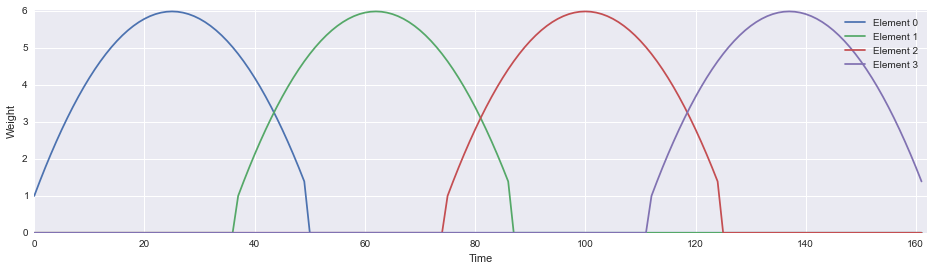

In [5]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4));
plt.plot(W.T);

plt.xlim(0, n_cov);
plt.ylim(0, max(W) + 0.05);
plt.xlabel('Time');
plt.ylabel('Weight');
plt.legend(['Element ' + str(i) for i in range(k)]);
# plt.savefig('sim_weights.png');

## Learn covariance dictionary using ALS vs. ADMM vs. PGM

#### Run ALS

In [42]:
reload(covdict) 
als = covdict.CovarianceDictionary(k=k, method='als', verbose=True, time=True, nls_beta=0.2, psdls_beta=0.2)
t = time.time()
Wals = als.fit_transform(X)
print str(time.time() - t) + ' seconds'

Initial gradient norm: 16968.265975.
Iter: 0. Projected gradient norm: 9808.712971. Objective: 0.055090.
Iter: 1. Projected gradient norm: 0.178836. Objective: 0.005404.
Iter: 2. Projected gradient norm: 0.186105. Objective: 0.000764.
Iter: 3. Final projected gradient norm 0.160003. Final objective 0.000226.
3.50029301643 seconds


#### Plot objective per iteration and final weights

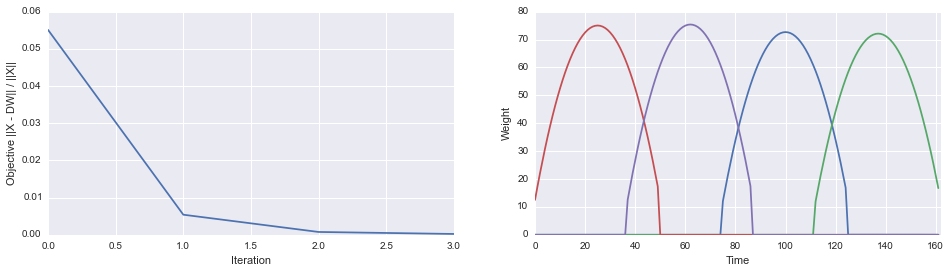

In [43]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4));

plt.subplot(121);
plt.plot(als.objective);
plt.xlabel('Iteration');
plt.ylabel('Objective ||X - DW|| / ||X||');

plt.subplot(122);
plt.plot(Wals.T);
plt.xlim(0, n_cov);
plt.xlabel('Time');
plt.ylabel('Weight');
# plt.savefig('sim_als.png');

#### Compare ALS-learned and true dictionary elements

In [44]:
# Match ALS-learned and corresponding dictionary elements, based on weight peaks
match_idx = argsort(argmax(Wals, axis=1))

# Correlate to account for scale factor
for a, b in zip(als.dictionary.T[match_idx], D.T):
    print corrcoef(a[triu_indices(n)], b)[0, 1]

0.999999961755
0.999999967236
0.999999974389
0.999999869699


#### Run PGM (default convergence tol = 1e-3)

In [45]:
reload(covdict) 
pgm = covdict.CovarianceDictionary(k=k, method='pgm', verbose=True, time=True, pgm_beta=0.6)
t = time.time()
Wpgm = pgm.fit_transform(X)
print str(time.time() - t) + ' seconds'

Initial gradient norm: 16968.265499.
Iter: 0. Projected gradient norm: 9808.713974. Objective: 0.055090.
Iter: 1. Projected gradient norm: 9808.713974. Objective: 0.055090.
Iter: 2. Projected gradient norm: 14247.632491. Objective: 0.047525.
Iter: 3. Projected gradient norm: 1688.257623. Objective: 0.020545.
Iter: 4. Projected gradient norm: 2027.679813. Objective: 0.017004.
Iter: 5. Projected gradient norm: 283.881867. Objective: 0.016288.
Iter: 6. Projected gradient norm: 451.668951. Objective: 0.016129.
Iter: 7. Projected gradient norm: 64.244696. Objective: 0.016093.
Iter: 8. Projected gradient norm: 103.874037. Objective: 0.016085.
Iter: 9. Projected gradient norm: 18.807119. Objective: 0.016083.
Iter: 10. Projected gradient norm: 26.600316. Objective: 0.016083.
Iter: 11. Final projected gradient norm 15.821672. Final objective 0.016083.
1.84292793274 seconds


#### Plot objective per iteration and final weights

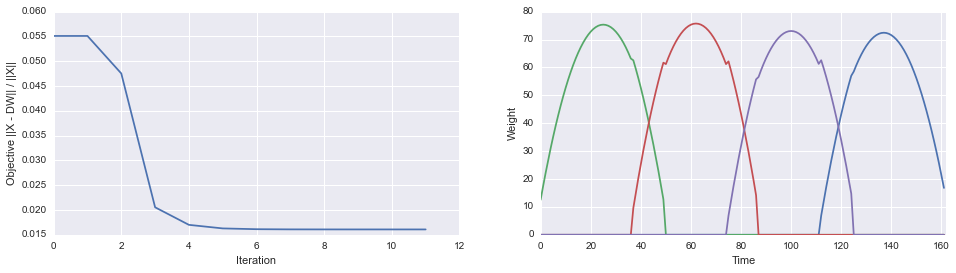

In [35]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4));

plt.subplot(121);
plt.plot(pgm.objective);
plt.xlabel('Iteration');
plt.ylabel('Objective ||X - DW|| / ||X||');

plt.subplot(122);
plt.plot(Wpgm.T);
plt.xlim(0, n_cov);
plt.xlabel('Time');
plt.ylabel('Weight');
# plt.savefig('sim_pgm.png');

#### Compare PGM-learned and true dictionary elements

In [36]:
# Match PGM-learned and corresponding dictionary elements, based on weight peaks
match_idx = argsort(argmax(Wpgm, axis=1))

# Correlate to account for scale factor
for a, b in zip(pgm.dictionary.T[match_idx], D.T):
    print corrcoef(a[triu_indices(n)], b)[0, 1]

0.999998159207
0.999956677623
0.999966039826
0.999999873718


#### Run ADMM

In [46]:
# Convergence quite sensitive to alpha and gamma (penalty and step size parameters)
reload(covdict)
admm = covdict.CovarianceDictionary(k=k, method='admm', verbose=True, time=True, admm_alpha=0.1)
t = time.time()
Wadmm = admm.fit_transform(X)
print str(time.time() - t) + ' seconds'

Iter: 0. Objective: 0.055090.
Iter: 27. Objective: 0.000105.
1.15086317062 seconds


#### Plot objective per iteration and final weights

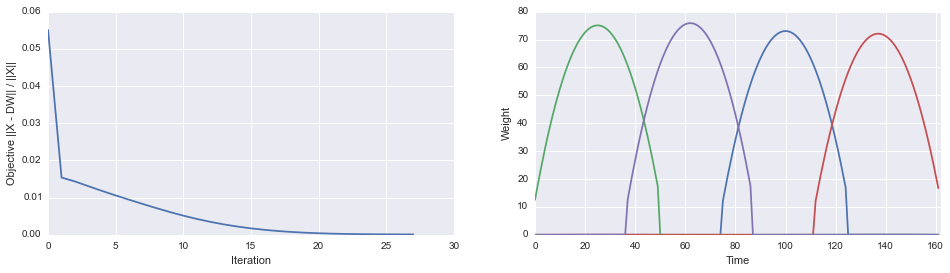

In [47]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4));

plt.subplot(121);
plt.plot(admm.objective);
plt.xlabel('Iteration');
plt.ylabel('Objective ||X - DW|| / ||X||');

plt.subplot(122);
plt.plot(Wadmm.T);
plt.xlim(0, n_cov);
plt.xlabel('Time');
plt.ylabel('Weight');
plt.savefig('sim_admm.png');

#### Compare ADMM-learned and true dictionary elements

In [48]:
# Match ADMM-learned and corresponding true dictionary elements, based on weight peaks
match_idx = argsort(argmax(Wadmm, axis=1))

# Correlate to account for scale factor
for a, b in zip(admm.dictionary.T[match_idx], D.T):
    print corrcoef(a[triu_indices(n)], b)[0, 1]

0.999999745308
0.999999999538
0.999999978094
0.999999383764


#### Compare objective over time for ALS vs. ADMM vs. PGM

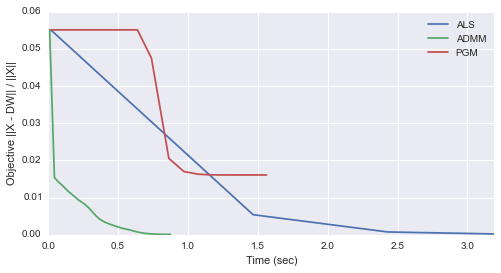

In [51]:
sns.set_style('darkgrid')
plt.figure(figsize=(8, 4));
plt.plot(als.times, als.objective);
plt.plot(admm.times, admm.objective);
plt.plot(pgm.times, pgm.objective);
plt.xlim(0, max((max((admm.times[-1], als.times[-1])), pgm.times[-1])));
plt.xlabel('Time (sec)');
plt.ylabel('Objective ||X - DW|| / ||X||');
plt.legend(['ALS', 'ADMM', 'PGM']);
#plt.savefig('sim_compare.png');

## Simulate multivariate Gaussian data

#### Draw samples from multivariate Gaussian and compute sample covariances

In [52]:
# Number of samples drawn per covariance matrix
n_samp = 2 * n

# Ignore non-PSD warnings due to numerical error (negative eigenvalues on order of 1e-17)
data = hstack([multivariate_normal(zeros(n), X.T[i], n_samp).T for i in range(n_cov)])

# Compute sample covariance matrices
Xsample = dstack([cov(chunk) for chunk in hsplit(data, n_cov)])

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: RuntimeWarning: covariance is not positive-semidefinite.


#### Learn dictionary using PGM (ALS times out across a range of hyperparameter settings)

In [76]:
reload(covdict)
pgm = covdict.CovarianceDictionary(k=k, method='pgm', verbose=True, time=True)
t = time.time()
Wpgm = pgm.fit_transform(Xsample)
print str(time.time() - t) + ' seconds'

Initial gradient norm: 20554.356467.
Iter: 0. Projected gradient norm: 12837.732632. Objective: 0.388301.
Iter: 1. Projected gradient norm: 8002.692151. Objective: 0.385124.
Iter: 2. Projected gradient norm: 1578.349043. Objective: 0.384752.
Iter: 3. Projected gradient norm: 2915.028393. Objective: 0.384660.
Iter: 4. Projected gradient norm: 461.246208. Objective: 0.384627.
Iter: 5. Projected gradient norm: 1320.083567. Objective: 0.384613.
Iter: 6. Projected gradient norm: 193.708242. Objective: 0.384607.
Iter: 7. Projected gradient norm: 623.115875. Objective: 0.384603.
Iter: 8. Projected gradient norm: 89.675268. Objective: 0.384602.
Iter: 9. Projected gradient norm: 297.416587. Objective: 0.384601.
Iter: 10. Projected gradient norm: 43.621713. Objective: 0.384601.
Iter: 11. Projected gradient norm: 142.699252. Objective: 0.384601.
Iter: 12. Projected gradient norm: 23.354283. Objective: 0.384601.
Iter: 13. Projected gradient norm: 69.160491. Objective: 0.384601.
Iter: 14. Final pro

#### Plot objective per iteration and final weights

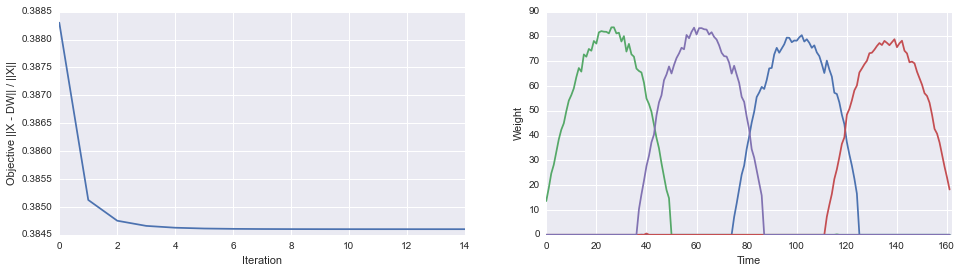

In [77]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4));

plt.subplot(121);
plt.plot(pgm.objective);
plt.xlabel('Iteration');
plt.ylabel('Objective ||X - DW|| / ||X||');

plt.subplot(122);
plt.plot(Wpgm.T);
plt.xlim(0, n_cov);
plt.xlabel('Time');
plt.ylabel('Weight');

#### Compare PGM-learned and true dictionary elements

In [78]:
# Match PGM-learned and true dictionary elements, based on weight peaks
match_idx = argsort(argmax(Wpgm, axis=1))

# Correlate to account for scale factor
print "Correlations between PGM-learned and true dictionary elements:"
for a, b in zip(pgm.dictionary.T[match_idx], D.T):
    print corrcoef(a[triu_indices(n)], b)[0, 1]

Correlations between PGM-learned and true dictionary elements:
0.997437645589
0.997207276543
0.99722638142
0.997502195438


#### Learn dictionary using ADMM

In [72]:
admm = covdict.CovarianceDictionary(k=k, method='admm', verbose=True, time=True, admm_alpha=0.1)
t = time.time()
Wadmm = admm.fit_transform(Xsample)
print str(time.time() - t) + ' seconds'

Iter: 0. Objective: 0.388301.
Iter: 15. Objective: 0.384159.
0.717633008957 seconds


#### Plot objective per iteration and final weights

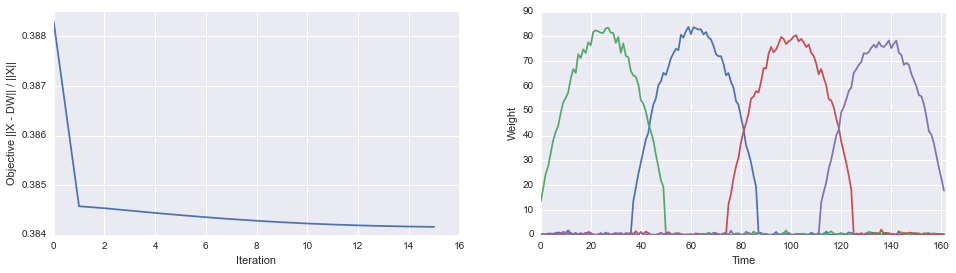

In [73]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4));

plt.subplot(121);
plt.plot(admm.objective);
plt.xlabel('Iteration');
plt.ylabel('Objective ||X - DW|| / ||X||');

plt.subplot(122);
plt.plot(Wadmm.T);
plt.xlim(0, n_cov);
plt.xlabel('Time');
plt.ylabel('Weight');

#### Compare ADMM-learned and true dictionary elements

In [74]:
# Match ADMM-learned to corresponding dictionary elements, based on weight peaks
match_idx = argsort(argmax(Wadmm, axis=1))

# Correlate to account for scale factor.
print "Correlations between ADMM-learned and true dictionary elements:"
for a, b in zip(admm.dictionary.T[match_idx], D.T):
    print corrcoef(a[triu_indices(n)], b)[0, 1]

Correlations between ADMM-learned and true dictionary elements:
0.997329948496
0.997182921626
0.997205941277
0.997422160984


#### Compare objective over time for PGM vs. ADMM

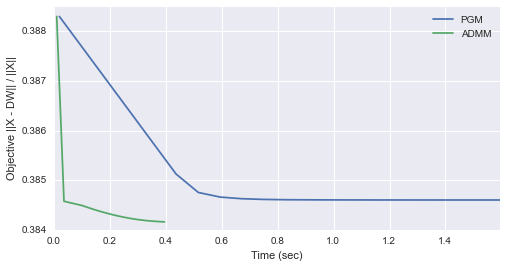

In [80]:
sns.set_style('darkgrid')
plt.figure(figsize=(8, 4));
plt.plot(pgm.times, pgm.objective);
plt.plot(admm.times, admm.objective);
plt.xlim(0, max((admm.times[-1], pgm.times[-1])));
plt.xlabel('Time (sec)');
plt.ylabel('Objective ||X - DW|| / ||X||');
plt.legend(['PGM', 'ADMM']);